# Desafio de Previsão de Sucesso de Startups
Este notebook documenta todo o processo para construir um modelo preditivo capaz de identificar startups de sucesso, seguindo as regras e critérios de avaliação do campeonato. Todas as etapas estão explicadas em português para facilitar o entendimento.

## 1. Carregamento e Inspeção dos Dados
Carregue os arquivos fornecidos e exiba informações básicas para entender a estrutura e o conteúdo dos dados.

In [36]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [37]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Sample submission shape:', sample_submission.shape)
train.head()

Train shape: (646, 33)
Test shape: (277, 32)
Sample submission shape: (277, 2)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


## 2. Limpeza dos Dados e Tratamento de Valores Ausentes
Identifique e trate valores ausentes e outliers. Documente as etapas de limpeza e as estratégias de imputação utilizadas.

In [38]:
# Check missing values and outliers
train.info()
train.isnull().sum()
train.describe()
test.info()
test.isnull().sum()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate             646 non-null    int64  
 14  category_c

,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants
count,277.000000,266.000000,273.000000,217.000000,224.000000,277.000000,277.000000,2.770000e+02,277.000000,277.000000,...,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000
mean,462.985560,2.497857,3.924286,3.312535,4.663348,7.155235,2.216606,1.591263e+07,1.675090,0.483755,...,0.032491,0.003610,0.364621,0.317690,0.241877,0.490975,0.328520,0.227437,0.119134,2.815103
std,271.068618,2.446842,2.825445,2.553868,2.847457,6.929857,1.463324,2.068785e+07,1.275122,0.500641,...,0.177621,0.060084,0.482195,0.466421,0.428995,0.500823,0.470525,0.419936,0.324532,1.831605
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,215.000000,0.722500,1.760000,1.250000,2.485000,3.000000,1.000000,2.238055e+06,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,464.000000,1.580000,3.510000,2.970000,4.165000,5.000000,2.000000,9.000000e+06,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
75%,692.000000,4.025000,5.560000,5.000000,6.722500,9.000000,3.000000,2.225000e+07,2.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.500000
max,922.000000,16.420000,16.420000,13.010000,13.010000,57.000000,10.000000,1.622641e+08,8.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000


In [39]:
# Impute missing values for continuous variables with median, categorical with mode
num_cols = [col for col in train.select_dtypes(include=['float64', 'int64']).columns if col != 'labels']
cat_cols = train.select_dtypes(include=['object']).columns
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
train[num_cols] = imputer_num.fit_transform(train[num_cols])
test[num_cols] = imputer_num.transform(test[num_cols])
train[cat_cols] = imputer_cat.fit_transform(train[cat_cols])
test[cat_cols] = imputer_cat.transform(test[cat_cols])

## 3. Codificação de Variáveis Categóricas
Codifique variáveis categóricas (ex: category_code) usando One-Hot Encoding. Garanta que todas as features estejam em formato adequado para os modelos de machine learning.

In [40]:
# One-Hot Encode category_code
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(train[['category_code']])
encoded_test = encoder.transform(test[['category_code']])
encoded_cols = encoder.get_feature_names_out(['category_code'])
train_encoded = pd.DataFrame(encoded_train, columns=encoded_cols, index=train.index)
test_encoded = pd.DataFrame(encoded_test, columns=encoded_cols, index=test.index)
train = pd.concat([train.drop('category_code', axis=1), train_encoded], axis=1)
test = pd.concat([test.drop('category_code', axis=1), test_encoded], axis=1)

## 4. Análise Exploratória e Visualização dos Dados
Realize a análise exploratória para entender distribuições, relações e correlações entre as variáveis. Visualize os principais insights usando matplotlib, seaborn e plotly.

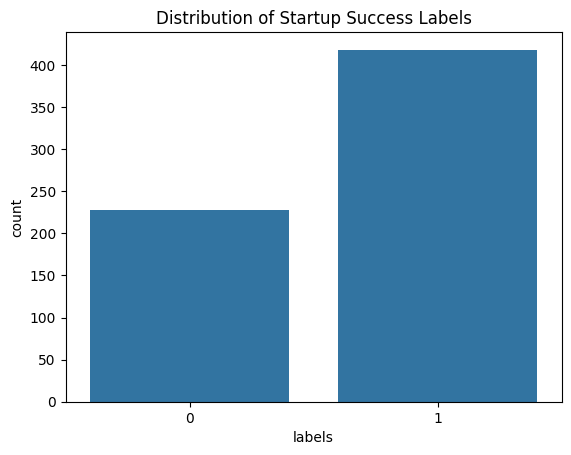

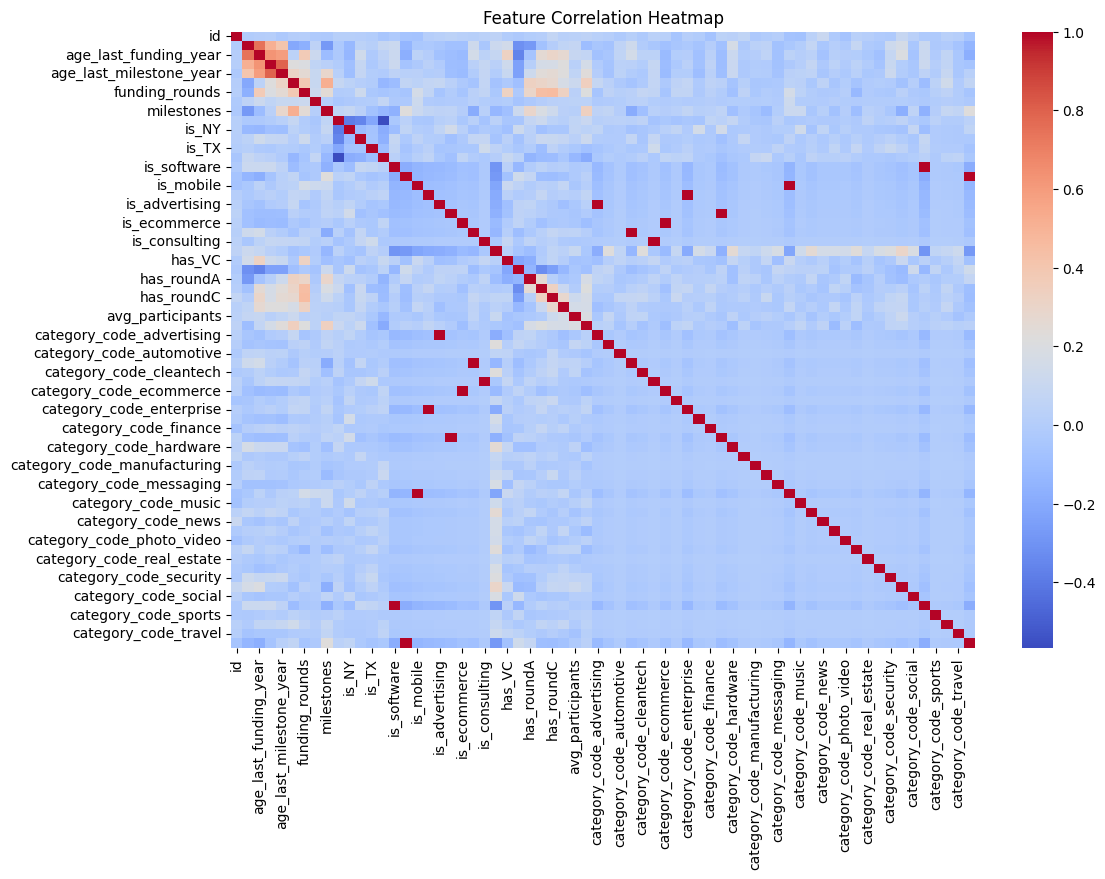

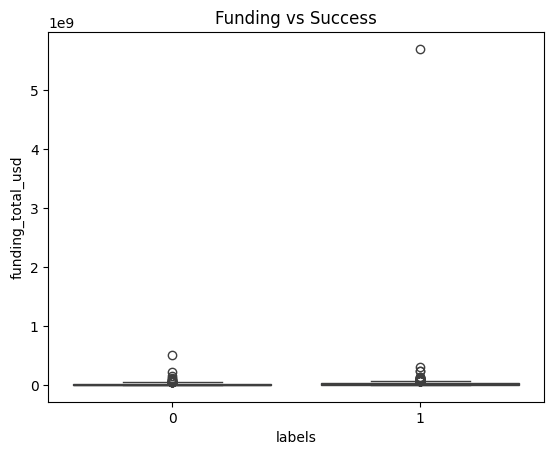

In [41]:
# Visualize target distribution
sns.countplot(x='labels', data=train)
plt.title('Distribution of Startup Success Labels')
plt.show()
# Correlation heatmap
corr = train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()
# Example: Funding vs Success
sns.boxplot(x='labels', y='funding_total_usd', data=train)
plt.title('Funding vs Success')
plt.show()

## 5. Formulação de Hipóteses
Formule três hipóteses sobre fatores que podem influenciar o sucesso das startups. Teste essas hipóteses utilizando os dados e visualizações.

**Hipótese 1:** Startups com maior captação total de recursos têm mais chance de sucesso.
**Hipótese 2:** Startups com mais conexões (relationships) têm maior probabilidade de sucesso.
**Hipótese 3:** Startups do setor de software têm maior taxa de sucesso em relação aos outros setores.

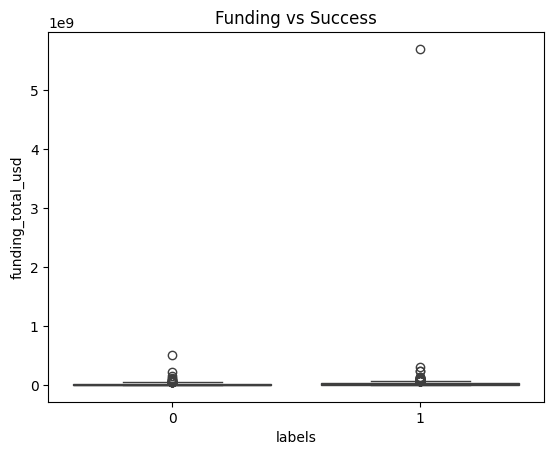

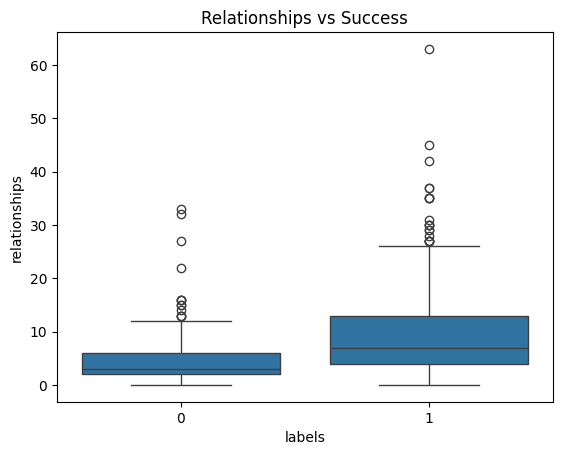

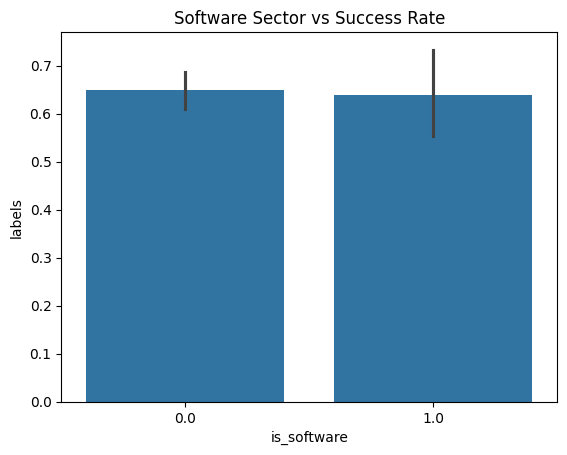

In [42]:
# Test Hypothesis 1: Funding vs Success
sns.boxplot(x='labels', y='funding_total_usd', data=train)
plt.title('Funding vs Success')
plt.show()
# Test Hypothesis 2: Relationships vs Success
sns.boxplot(x='labels', y='relationships', data=train)
plt.title('Relationships vs Success')
plt.show()
# Test Hypothesis 3: Software Sector vs Success
sns.barplot(x='is_software', y='labels', data=train)
plt.title('Software Sector vs Success Rate')
plt.show()

## 6. Seleção de Features
Selecione as variáveis mais relevantes para o modelo com base na análise exploratória e nas hipóteses formuladas. Documente o processo de seleção.

In [43]:
# Engenharia de features avançada
train['funding_per_round'] = train['funding_total_usd'] / (train['funding_rounds'] + 1)
test['funding_per_round'] = test['funding_total_usd'] / (test['funding_rounds'] + 1)
train['milestones_per_round'] = train['milestones'] / (train['funding_rounds'] + 1)
test['milestones_per_round'] = test['milestones'] / (test['funding_rounds'] + 1)
train['vc_software'] = train['has_VC'] * train['is_software']
test['vc_software'] = test['has_VC'] * test['is_software']
train['angel_software'] = train['has_angel'] * train['is_software']
test['angel_software'] = test['has_angel'] * test['is_software']
# Log-transform para funding_total_usd e milestones
train['log_funding_total_usd'] = np.log1p(train['funding_total_usd'])
test['log_funding_total_usd'] = np.log1p(test['funding_total_usd'])
train['log_milestones'] = np.log1p(train['milestones'])
test['log_milestones'] = np.log1p(test['milestones'])

In [44]:
# Seleção de features incluindo variáveis de engenharia e log-transformadas
selected_features = [
    'funding_total_usd', 'relationships', 'is_software', 'funding_rounds', 'milestones',
    'avg_participants', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
    'funding_per_round', 'milestones_per_round', 'vc_software', 'angel_software',
    'log_funding_total_usd', 'log_milestones',
    # Add other relevant dummies and encoded category columns
    *[col for col in train.columns if col.startswith('category_code_')]
 ]
X = train[selected_features]
y = train['labels']
X_test = test[selected_features]

## 7. Construção e Avaliação do Modelo
Construa e avalie um modelo de classificação binária (Gradient Boosting). Avalie o desempenho usando acurácia, precisão, recall, F1-score e matriz de confusão.

In [45]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Build and train Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_scaled, y_train)
# Evaluate model
y_pred = model.predict(X_val_scaled)
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1-score:', f1_score(y_val, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))
print('Classification Report:\n', classification_report(y_val, y_pred))

Accuracy: 0.7538461538461538
Precision: 0.7403846153846154
Recall: 0.9390243902439024
F1-score: 0.8279569892473119
Confusion Matrix:
 [[21 27]
 [ 5 77]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.44      0.57        48
           1       0.74      0.94      0.83        82

    accuracy                           0.75       130
   macro avg       0.77      0.69      0.70       130
weighted avg       0.77      0.75      0.73       130



## 8. Otimização de Hiperparâmetros
Otimize os hiperparâmetros do modelo usando GridSearchCV. Documente o processo e reporte os melhores parâmetros e métricas obtidas.

In [46]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
}
grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
print('Best parameters:', grid.best_params_)
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_val_scaled)
print('Tuned Accuracy:', accuracy_score(y_val, y_pred_best))
print('Tuned Precision:', precision_score(y_val, y_pred_best))
print('Tuned Recall:', recall_score(y_val, y_pred_best))
print('Tuned F1-score:', f1_score(y_val, y_pred_best))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Tuned Accuracy: 0.7538461538461538
Tuned Precision: 0.7403846153846154
Tuned Recall: 0.9390243902439024
Tuned F1-score: 0.8279569892473119


## 9. Geração do Arquivo de Submissão
Utilize o modelo treinado para prever no conjunto de teste e prepare o arquivo de submissão conforme o formato exigido pela competição.

In [47]:
# Predict on test set and prepare submission
test_pred = best_model.predict(X_test_scaled)
submission = sample_submission.copy()
submission['labels'] = test_pred
submission.to_csv('submission.csv', index=False)
print('Submission file generated: submission.csv')

Submission file generated: submission.csv
